In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/kishan/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kishan/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kishan/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kishan/.local/lib/python3.7/site-packages/tensorflow/python

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

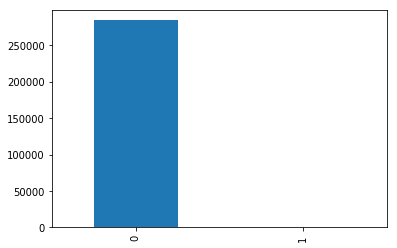

In [5]:
data.Class.value_counts().plot.bar()

In [6]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
data.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

We will build a simple logistic regression classifer and compare the results for the classifier without SMOTE to with SMOTE.

In [8]:
data = data.drop(['Time'], axis = 1)
X = data.drop(['Class'],axis = 1)
y = data.Class

In [9]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# split into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2, shuffle = True, stratify = y)

In [11]:
# import logistic regression model and accuracy_score metric
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(solver = 'lbfgs')

## Without SMOTE

In [12]:
# fit the model
clf.fit(X_train, y_train)

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for testing dataset
test_pred = clf.predict(X_test)

In [13]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred, y_test))

Accuracy score for Training Dataset =  0.9991248296824232
Accuracy score for Testing Dataset =  0.9992871354549033


You might think that the model has performed exceptionally well. Well, that's not the case. Let us examine the confusion matrix for our predictions.

In [14]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train, train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted       0    1     All
True                          
0          190457   33  190490
1             134  196     330
All        190591  229  190820


134 out of 330 instances which belong to class 1 have been classifed as class 0

In [15]:
134/330

0.40606060606060607

That is a massive 41%! We are classifying 41% of the fraud cases as not fraud. This is going to cost some serious losses to the credit card company. You can observe this similarly in the confusion matrix of the Testing Dataset.

In [16]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test, test_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted      0    1    All
True                        
0          93815   10  93825
1             57  105    162
All        93872  115  93987


In [17]:
57/162

0.35185185185185186

35% of fraud cases are misclassified as not fraud. Not a good thing to happen in a credit card company.

The higher accuracy is not due to correct classification. The model has predicted the majority class for almost all the examples. And since about 99.8% of the examples actually belong to this class, it leads to such high accuracy scores.

## Using SMOTE

Researchers have found that balancing the data will to better classification models. We will try balancing our data using SMOTE(Synthetic Minority Over-sampling TEchnique )

  Just like the name suggests, the technique generates synthetic data for the minority class.

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [19]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train)

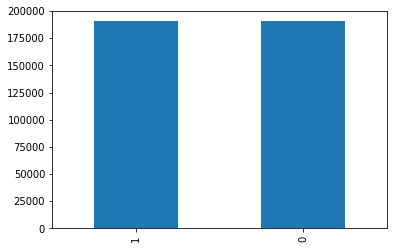

In [20]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [24]:
pd.Series(y_train_new).value_counts()

1    190490
0    190490
dtype: int64

Hurray! Balanaced data at last!

In [25]:
# fit the model
clf.fit(X_train_new, y_train_new)

# prediction for Training data
train_pred_sm = clf.predict(X_train_new)

# prediction for Testing data
test_pred_sm = clf.predict(X_test)

In [26]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_sm, y_train_new))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, y_test))

Accuracy score for Training Dataset =  0.9425271667804084
Accuracy score for Testing Dataset =  0.9720812452786024


Our accuracy has reduced. But our model has definitely improved. Observe the confusion matrices.

In [27]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train_new, train_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted       0       1     All
True                             
0          185279    5211  190490
1           16685  173805  190490
All        201964  179016  380980


In [28]:
16685/190490

0.08758989973226941

16685 out of 190490 fraud cases have been classified as not fraud. This is a mere 8.7% compared to the previous 41%.

A vast improvement!

Same is the case with the Testing Dataset.

In [29]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test.ravel(), test_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted      0     1    All
True                         
0          91213  2612  93825
1             12   150    162
All        91225  2762  93987


In [30]:
12/162

0.07407407407407407

Roughly 7.4% of the fraud classes have been classified as not fraud.

## Conclusion
One might argue that the reduced accuracy is an indicator of lower model performance. However, this is not true.

Error in prediction can be made in two ways:

1. Classifying **not fraud** as **fraud**
2. Classifying **fraud** as **not fraud**

It should not be hard to understand that the second error is costlier than the first.

The objective of each classification problem is different. So make sure to evaluate each model with respect to its own objective instead of merely judging it on its accuracy.